
Self Note: With SMP, should use the preprocess_fn for image preprocessing as the trained encoder expects the inputs to be preprocessed a certain way.

*Negative dice loss: need to make sure mask is [0,1], and it has a channel. Otherwise SMP loss functions may not work as intended

Don't use normalization from albumentations. Preprocess_fn is sufficient

Froze the encoder portion. Only training the decoder portion due to compute limits

*Negative IOU: caused by img/mask in format (h ,w, channel). needs to be (channel, h, w) before being passed into model

In [ ]:
pip install segmentation-models-pytorch

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
#core pacakges
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import cv2
from shutil import copyfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/!personalMLProject/portraitSegmentation/portraitSegData/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: ytrain/13698.png        
  inflating: ytrain/13699.png        
  inflating: ytrain/13700.png        
  inflating: ytrain/13701.png        
  inflating: ytrain/13702.png        
  inflating: ytrain/13703.png        
  inflating: ytrain/13704.png        
  inflating: ytrain/13705.png        
  inflating: ytrain/13706.png        
  inflating: ytrain/13707.png        
  inflating: ytrain/13708.png        
  inflating: ytrain/13709.png        
  inflating: ytrain/13710.png        
  inflating: ytrain/13711.png        
  inflating: ytrain/13712.png        
  inflating: ytrain/13713.png        
  inflating: ytrain/13714.png        
  inflating: ytrain/13715.png        
  inflating: ytrain/13716.png        
  inflating: ytrain/13717.png        
  inflating: ytrain/13718.png        
  inflating: ytrain/13719.png        
  inflating: ytrain/13720.png        
  inflating: ytrain/13721.png        
  inflating: ytrain/13722.png        

In [ ]:
xtest_dir = '/content/xtest'
xtrain_dir = '/content/xtrain'
ytest_dir = '/content/ytest'
ytrain_dir = '/content/ytrain'

In [ ]:
def visualize_dataset(aDataset):
  fig, axes = plt.subplots(5, 2, figsize=(10, 20))

  for i in range(5):
    random_index = random.randint(0, len(aDataset) - 1)
    image, mask = aDataset[random_index]

    numpy_mask = mask.detach().numpy()
    numpy_image = image.detach().numpy()

    #switch channel to last position for visualization
    if numpy_image.shape[0] == 3:
        numpy_image = np.transpose(numpy_image, (1, 2, 0))
    if numpy_mask.shape[0] == 1:
        numpy_mask = np.transpose(numpy_mask, (1,2,0))

    numpy_image = numpy_image.astype(np.uint8)

    axes[i, 0].imshow(numpy_image)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(numpy_mask, cmap='gray')
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')

    print (f'image shape {numpy_image.shape}')
    print (f'mask shape {numpy_mask.shape}')
    #print(f'mask tensor {mask}')
    unique_vals_mask = torch.unique(mask)
    #print(f'mask tensor unqiue vals {unique_vals_mask}')

    #print(f'image tensor {image}')
    unique_vals_img = torch.unique(image)
    #print(f'image tensor unqiue vals {unique_vals_img}')

  plt.tight_layout()
  plt.show()

In [ ]:
#model, training params
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
EPOCHS=10

In [ ]:
#using SMP to create model
model = smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=ACTIVATION,
)
model.to(DEVICE)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [ ]:
#smp handles image preprocessing
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

In [ ]:
#custom dataset
class portraitSegmentationDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None, preprocessing_fn=None):
      self.image_dir = image_dir
      self.mask_dir = mask_dir
      self.transform = transform
      self.preprocessing_fn = preprocessing_fn
      self.images = os.listdir(image_dir)

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img_name = self.images[idx]
      img_path = os.path.join(self.image_dir, img_name)
      mask_path = os.path.join(self.mask_dir, img_name)

      # Load images as uint8
      image = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
      mask = np.array(Image.open(mask_path).convert('L'), dtype=np.uint8)

      mask[mask == 255] = 1
      # mask[mask != 1] = 0


      # image = cv2.imread(img_path)
      # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      # mask = cv2.imread(mask_path, 0)

      # # Ensure mask values are 0 and 1 for binary segmentation
      mask[mask == 255] = 1
      # mask[mask != 1] = 0

      if self.transform:
          augmentations = self.transform(image=image, mask=mask)
          image = augmentations['image']
          mask = augmentations['mask']


      if self.preprocessing_fn:
          #to (H, W, C) as required by preprocess_fn from smp
          image = image.permute(1, 2, 0).cpu().numpy()

          image = self.preprocessing_fn(image)
          # Convert image to tensor after preprocessing
          image = torch.from_numpy(image).permute(2, 0, 1).float()

          #adding channel to mask to avoid negative dice loss
          mask = torch.unsqueeze(mask, 0)
          mask = mask.float()


      return image, mask

In [ ]:
#alubmentations transformations
train_preprocess = A.Compose([
    # A.Resize(128, 128),
    #alubmentation normalize distinguishes images(3 chan) from masks (1 chan)

    #do not normalize images when using efficent net as encoder since it expects range 0-255

    #A.Normalize(mean=[0.0, 0.0, 0.0],
                # std=[1.0, 1.0, 1.0],
                # max_pixel_value=255.0,),
    A.Rotate(limit=35, p=0.2),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.1),
    A.Affine(scale=1.0, translate_percent=0.1, shear=5, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=1.0),
    ToTensorV2(),
])

val_preprocess = A.Compose([
    # A.Resize(128, 128),

    #don't normalize again since using efficentnet with expected range for images 0-255

    # A.Normalize(mean=[0.0, 0.0, 0.0],
    #             std=[1.0, 1.0, 1.0],
    #             max_pixel_value=255.0,),
    ToTensorV2(),
])

In [ ]:
#takes in path for train and its mask dir, split img/mask pathes for train/val split. Stored in val folder
def train_dir_to_train_val_split(train_img_dir, train_mask_dir):
  # List all files in the image directory
  image_filenames = os.listdir(train_img_dir)

  mask_filenames = os.listdir(train_mask_dir) #can do this because mask, image have the same names

  # Sort and match image files with mask files by name
  image_filenames.sort()
  mask_filenames.sort()

  train_images, val_images, train_masks, val_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
  )

  trainSplit_image_dir = '/content/xtrain_split'
  val_image_dir = '/content/xval_split'
  trainSplit_mask_dir = '/content/ytrain_split'
  val_mask_dir = '/content/yval_split'

  os.makedirs(trainSplit_image_dir, exist_ok=True)
  os.makedirs(val_image_dir, exist_ok=True)
  os.makedirs(trainSplit_mask_dir, exist_ok=True)
  os.makedirs(val_mask_dir, exist_ok=True)

  # Copy training files
  for img, mask in zip(train_images, train_masks):
      copyfile(os.path.join(train_img_dir, img), os.path.join(trainSplit_image_dir, img))
      copyfile(os.path.join(train_mask_dir, mask), os.path.join(trainSplit_mask_dir, mask))

  # Copy validation files
  for img, mask in zip(val_images, val_masks):
      copyfile(os.path.join(train_img_dir, img), os.path.join(val_image_dir, img))
      copyfile(os.path.join(train_mask_dir, mask), os.path.join(val_mask_dir, mask))

  print(f'Training images: {len(train_images)}, Validation images: {len(val_images)}')


In [ ]:
#train test split with new folders
train_dir_to_train_val_split(xtrain_dir, ytrain_dir)

Training images: 14958, Validation images: 3740


In [ ]:
# Initialize dataset with transformations and preprocessing function
xtrain_dir = '/content/xtrain_split'
ytrain_dir = '/content/ytrain_split'
xval_dir = '/content/xval_split'
yval_dir = '/content/yval_split'

train_dataset = portraitSegmentationDataset(image_dir=xtrain_dir, mask_dir=ytrain_dir, transform=train_preprocess, preprocessing_fn=preprocessing_fn)
val_dataset = portraitSegmentationDataset(image_dir=xval_dir, mask_dir=yval_dir, transform=val_preprocess, preprocessing_fn=preprocessing_fn)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


image shape (128, 128, 3)
mask shape (128, 128, 1)
image shape (128, 128, 3)
mask shape (128, 128, 1)
image shape (128, 128, 3)
mask shape (128, 128, 1)
image shape (128, 128, 3)
mask shape (128, 128, 1)
image shape (128, 128, 3)
mask shape (128, 128, 1)


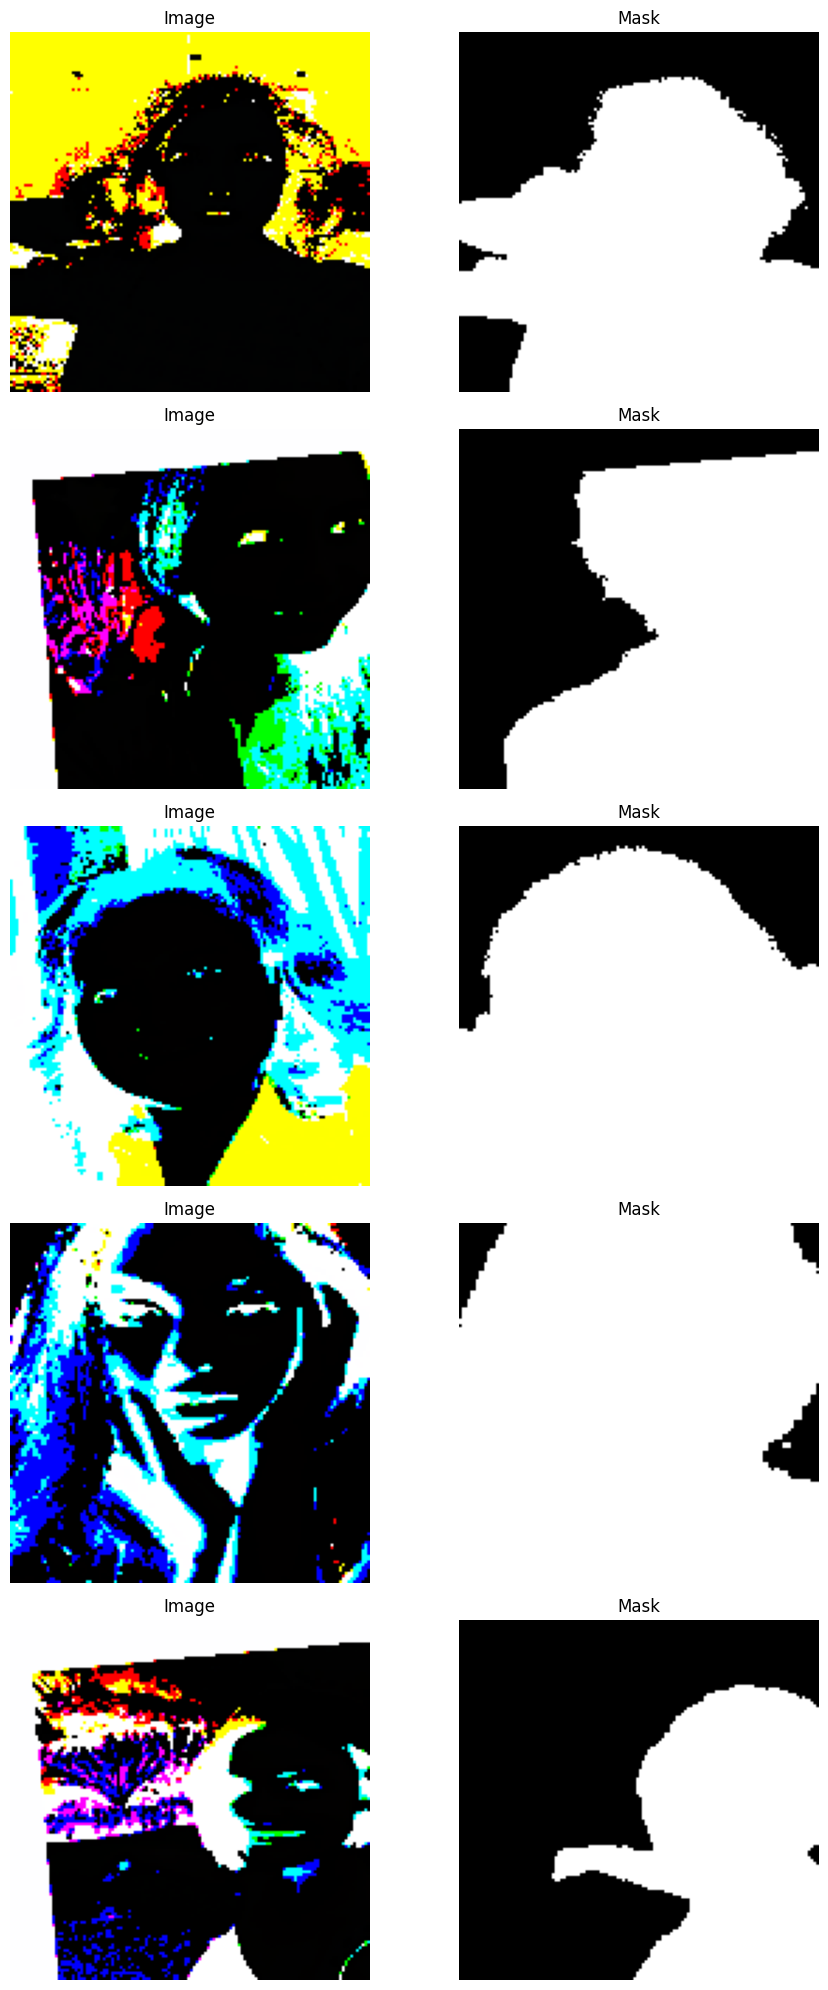

In [ ]:
visualize_dataset(train_dataset)

In [ ]:
# loss = smp.losses.DiceLoss(mode='binary')
#for smp.losses
#loss.__name__ = 'Dice_loss'

#utils implementation: https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/segmentation_models_pytorch/utils/losses.py
#(might be deprecated soon)
#using utils.losses instead:
loss = smp.utils.losses.DiceLoss()


metrics = [
    smp.utils.metrics.IoU(threshold=0.5) #should just use utils implementaiton. otherwise loss can't go down
]

#encoder freezing
# for param in model.encoder.parameters():
#     param.requires_grad = False
#decoder portion, using lr of 0.0001. Lr scheduler?
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [1]:
#epoch runner from smp for trainning with dataloader
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

NameError: name 'smp' is not defined

In [ ]:
def save_checkpoint(model, optimizer, epoch, file_path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, file_path)

In [ ]:
#code for loading checkpoints
def load_checkpoint(file_path, model, optimizer):
    checkpoint = torch.load(file_path)
    #model and optimizer are updated in place
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return epoch

In [ ]:
#training loop
max_score = 0

for i in range(0, EPOCHS):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)

    model.eval()
    with torch.no_grad():
        valid_logs = valid_epoch.run(val_loader)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model.state_dict(), '/content/drive/MyDrive/!personalMLProject/portraitSegmentation/portrait_best_model.pth')
        print('Best model saved')

    if i + 1 % 5 == 0:
        checkpoint_path = f'/content/drive/MyDrive/!personalMLProject/portraitSegmentation/portrait_checkpoint_model.pth'
        save_checkpoint(model, optimizer, i, checkpoint_path)
        print('Model checkpoint saved!')



Epoch: 0
valid: 100%|██████████| 935/935 [01:06<00:00, 14.05it/s, dice_loss - 0.02207, iou_score - 0.9669]
Best model saved

Epoch: 1
valid: 100%|██████████| 935/935 [01:05<00:00, 14.18it/s, dice_loss - 0.0159, iou_score - 0.9722]
Best model saved

Epoch: 2
valid: 100%|██████████| 935/935 [01:07<00:00, 13.86it/s, dice_loss - 0.01412, iou_score - 0.974]
Best model saved

Epoch: 3
valid: 100%|██████████| 935/935 [01:06<00:00, 13.96it/s, dice_loss - 0.01275, iou_score - 0.9762]
Best model saved

Epoch: 4
valid: 100%|██████████| 935/935 [01:07<00:00, 13.89it/s, dice_loss - 0.01141, iou_score - 0.9783]
Best model saved

Epoch: 5
valid: 100%|██████████| 935/935 [01:07<00:00, 13.84it/s, dice_loss - 0.01112, iou_score - 0.9787]
Best model saved

Epoch: 6
valid: 100%|██████████| 935/935 [01:04<00:00, 14.50it/s, dice_loss - 0.0108, iou_score - 0.9791]
Best model saved

Epoch: 7
valid: 100%|██████████| 935/935 [01:05<00:00, 14.28it/s, dice_loss - 0.01062, iou_score - 0.9795]
Best model saved

Ep

In [ ]:
#testing model
model_weights = torch.load('/content/drive/MyDrive/!personalMLProject/portraitSegmentation/portrait_best_model.pth')
model = smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=ACTIVATION,
)
model.load_state_dict(model_weights)
model.eval()
test_dataset = portraitSegmentationDataset(image_dir=xtest_dir, mask_dir=ytest_dir, transform=val_preprocess, preprocessing_fn=preprocessing_fn)
test_dataloader = DataLoader(test_dataset)


In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)
with torch.no_grad():
  logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 3740/3740 [04:02<00:00, 15.44it/s, dice_loss - 0.007209, iou_score - 0.986]


In [ ]:
# helper function for data visualization
def visualize_predictions(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

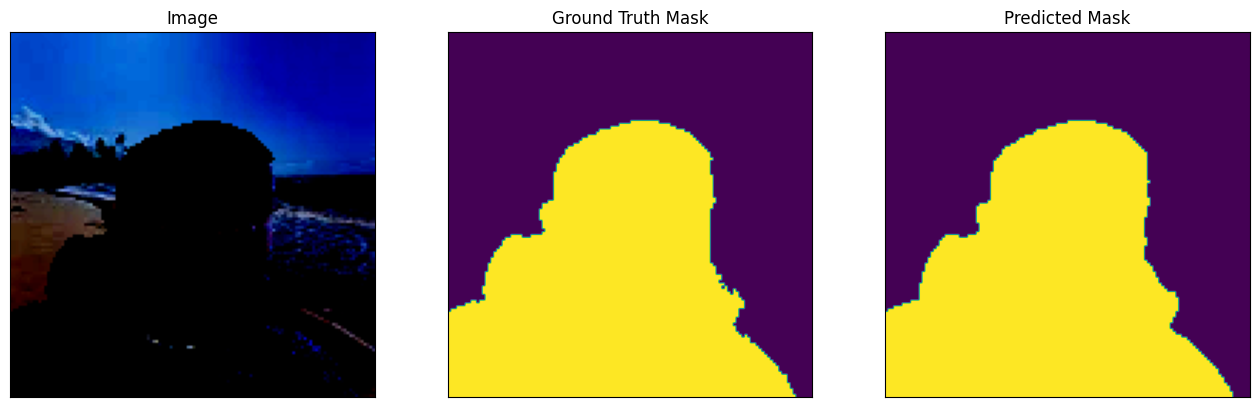

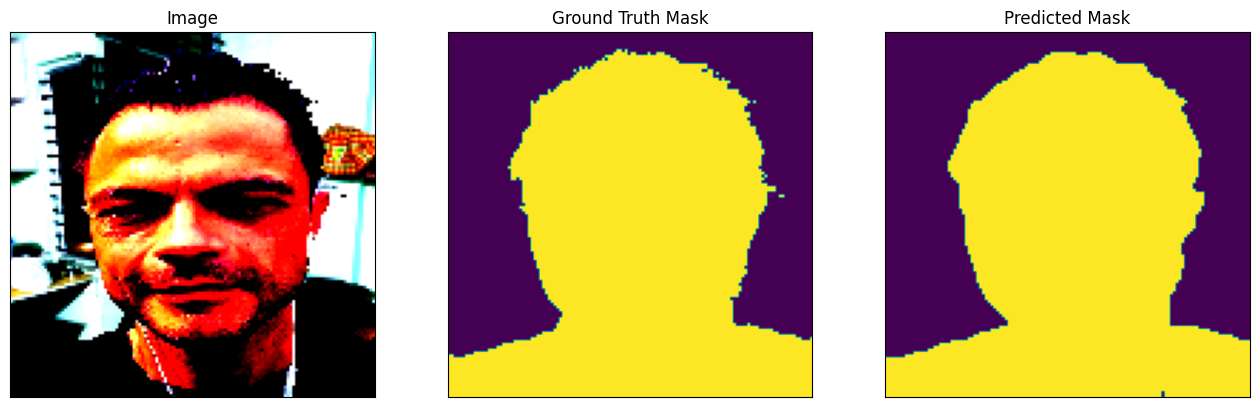

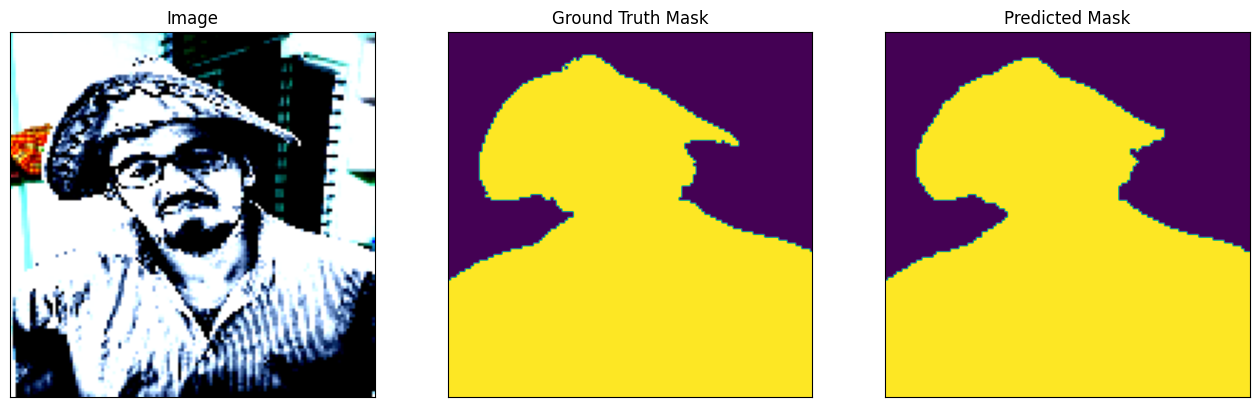

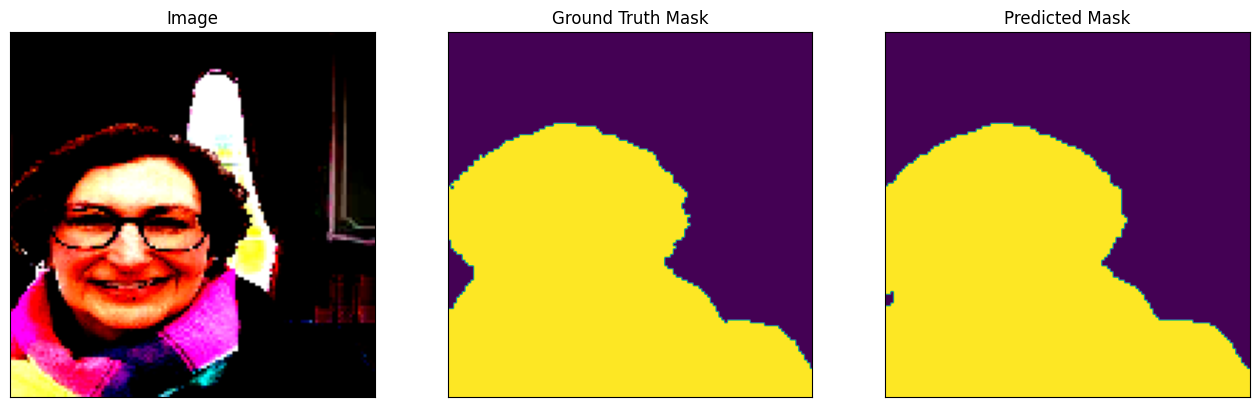

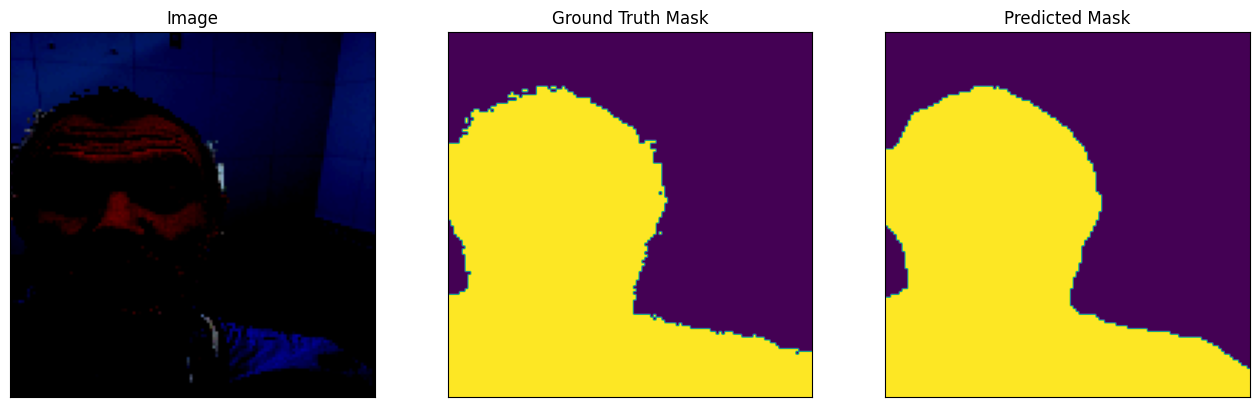

In [ ]:
#prediction visualization
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset[n][0].cpu().numpy().transpose(1, 2, 0)
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.unsqueeze(image, 0).to(DEVICE)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize_predictions(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )